<a href="https://colab.research.google.com/github/Gus-1003/TADS_Projeto_PalmaS/blob/main/PrimeirosTestes/Teste3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Teste 3 - Implementação das Features de cor somadas as Features geometricas:

## Importando Bibliotecas:

In [82]:
import cv2 as cv
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.cluster import KMeans

In [83]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Lendo Imagem:

In [84]:
file = '/content/drive/MyDrive/Colab Notebooks/control_img_2.jpeg'
#file = '/content/drive/MyDrive/Colab Notebooks/fig_true_19.jpg'

im = cv.imread(file)

## Pré-Processamento:

### Visualizando imagem original:

In [85]:
#cv2_imshow(im)

### Estudo das dimenssões:

In [86]:
# Instrução para descobrir o tamanho da dimensão da imagem (Linhas x Colunas)
print('Dim:' + str(im.shape))

Dim:(960, 1600, 3)


### corte:



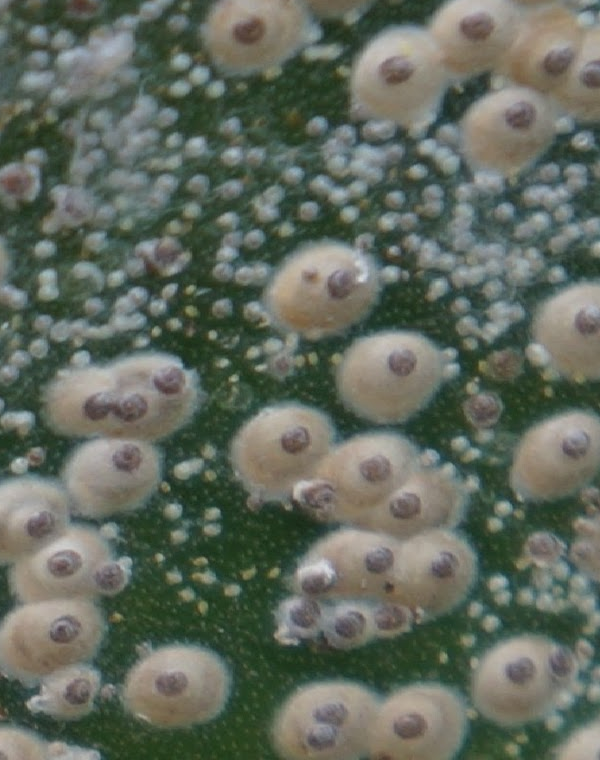

In [87]:
corteIm = im[200:960, 200:800]
compara = corteIm.copy()
#corteIm = im
cv2_imshow(corteIm)

### Aplicação de filtros:

In [88]:
median = cv.medianBlur(im, 5)

gauss = cv.GaussianBlur(im, (5,5), 0)

images = np.concatenate((median, gauss), axis=1)

In [89]:
#cv2_imshow(images)

### Visualização do Histograma:

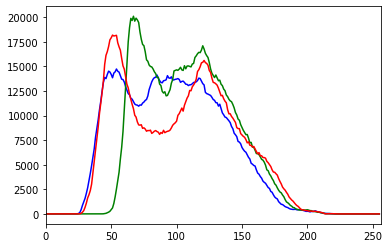

In [90]:
gauss_split_channels = cv.split(gauss)

# numero de bins do histograma
hist_size = 256

# faixa de valores de cada canal
hist_range = (0, 256) #0-255 (8 bits)
accumulate = False

color = ('b','g','r') #h, s, v

for i,col in enumerate(color):

    histr = cv.calcHist(gauss_split_channels,[i],None, [hist_size], hist_range, accumulate=accumulate)

    plt.plot(histr, color = col)

    plt.xlim([0,256])

    
plt.show()

### Teste: Mudança para tons de cinza diretamente

In [91]:
gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
#cv2_imshow(gray)

### Teste: Uso da imagem com filtro gaussiano:

split dos 3 canais - O canal azul si saiu melhor:

In [92]:
(B, G, R) = cv.split(gauss) 
#cv2_imshow(cv.hconcat([R, G, B]))

corte da região de interesse - A imagem original possuia muito desfoco

Dim:(760, 600)


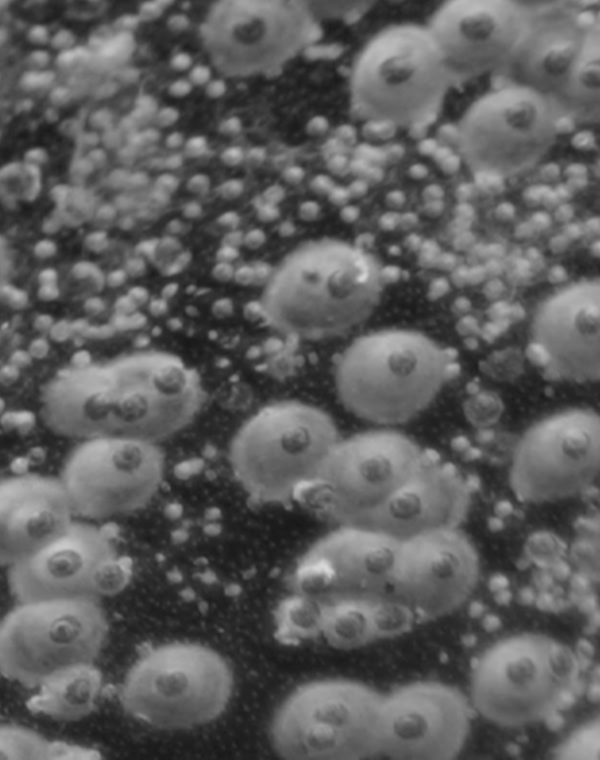

In [93]:
corte = B[200:960, 200:800] # cortando uma parte da imagem
origem = corte.copy()
print('Dim:' + str(corte.shape))
cv2_imshow(corte)

Limiarização - Usando a técnica de Otsu

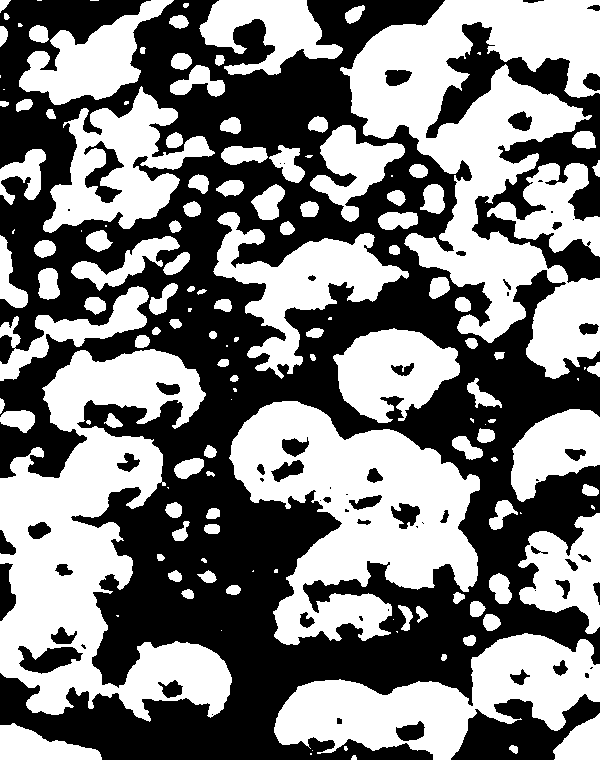

In [94]:
ret, thresh = cv.threshold(corte, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
cv2_imshow(thresh)

### Buscando Contornos:

In [95]:
#contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
contours, hierarchy = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

Encontrei 142 contornos
Area: 15.5
Perimetro: 16.242640614509583
Area estimada do objeto preenchido em relação à área total: 0.03875 %


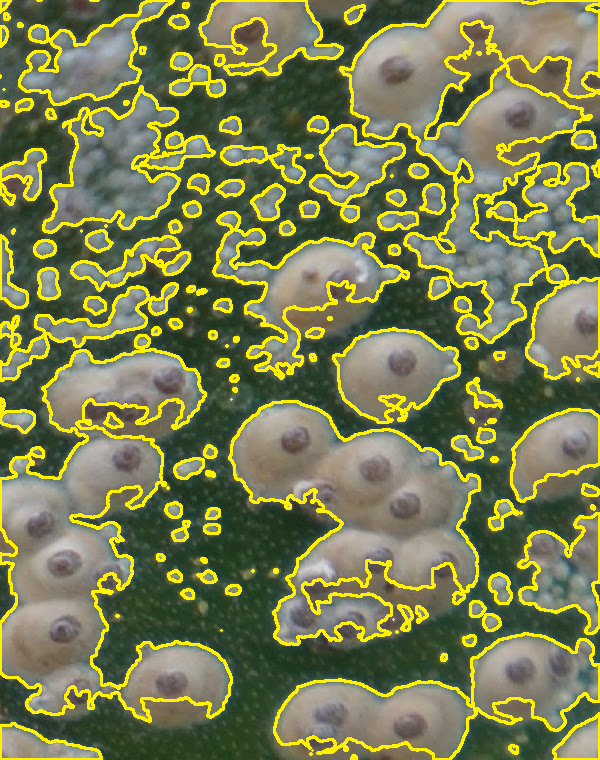

In [96]:
print('Encontrei ' + str(len(contours)) + ' contornos')
area = cv.contourArea(contours[0])
perimeter = cv.arcLength(contours[0],True) #if not convex, False

print('Area: ' + str(area))
print('Perimetro: ' + str(perimeter))

print('Area estimada do objeto preenchido em relação à área total: ' + str((area/40000)*100) + ' %')

cv.drawContours(corteIm, contours, -1, (0,242,255), 2); #unico contorno 0
cv2_imshow(corteIm)

Foram encontrados 142 objetos com seus contornos


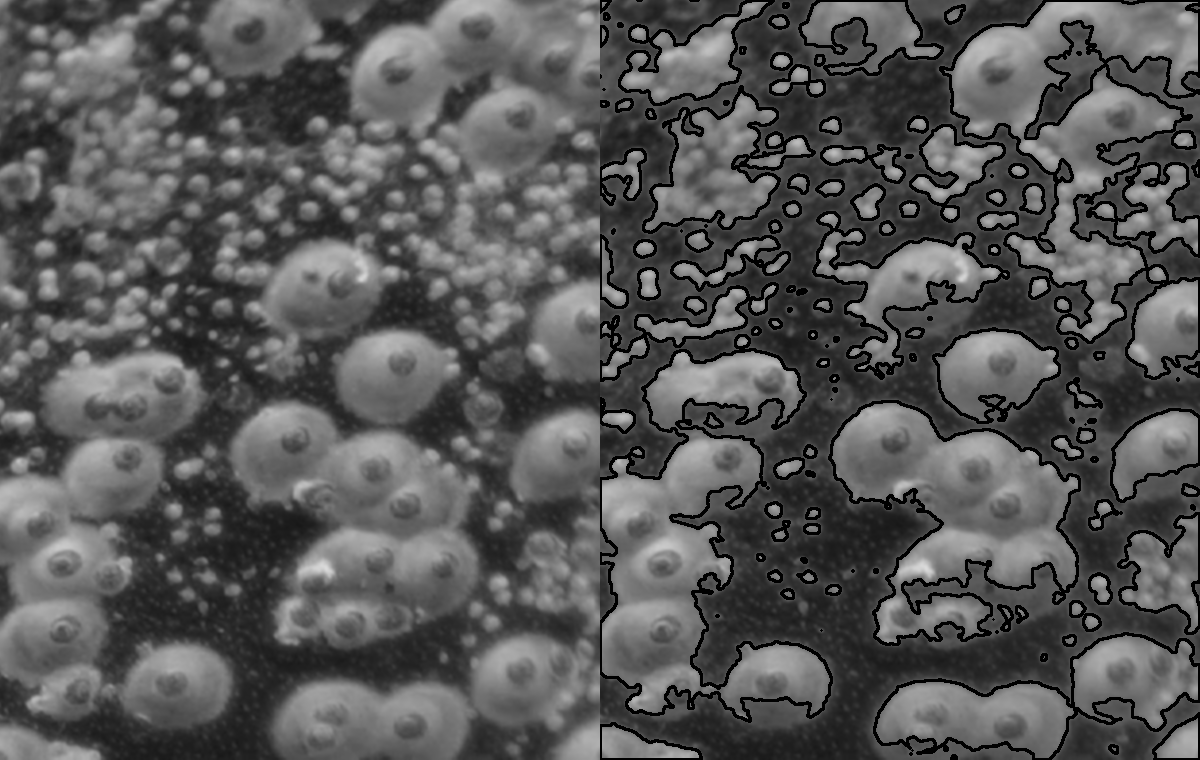

In [97]:
print ('Foram encontrados ' + str(len(contours)) + ' objetos com seus contornos')

cv.drawContours(corte, contours, -1, (0,242,255), 2)
cv2_imshow(cv.hconcat([origem, corte]))

### Laço: contours

In [99]:
def extract_image(thresh, cnt):
  # np.zeros: Cria uma matriz com determinadas dimensões
  im_blank = np.zeros(im.shape, np.uint8) 

  cv.drawContours(im_blank, [cnt], -1, 255, -1)

  mask = im_blank == 255

  im_filter = im[mask]

  return im_filter

In [100]:
areas = []
perimeters = []
centroids_x = []
centroids_y = []
aspect_ratio = [] #It is the ratio of width to height of bounding rect of the object.
extent = [] #Extent is the ratio of contour area to bounding rectangle area.
solidity = [] #Solidity is the ratio of contour area to its convex hull area.
equivalent_diameter = [] #Equivalent Diameter is the diameter of the circle whose area is same as the contour area.
r_mean = []
r_min = []
r_max = []
r_std = []
g_mean = []
g_min = []
g_max = []
g_std = []
b_mean = []
b_min = []
b_max = []
b_std = []
width = []
height = []
angle = []
radius = []


im_split_channels = cv.split(im)
album = [] 

for c in contours:
    M = cv.moments(c)
    
    areas.append(M['m00'])
    perimeters.append(cv.arcLength(c,True)) #if not convex, False
    
    x,y,w,h = cv.boundingRect(c)
    aspect_ratio.append(float(w)/h)
    width.append(w)
    height.append(h)
    rect = cv.minAreaRect(c)
    circle = cv.minEnclosingCircle(c)
    angle.append(rect[2])
    radius.append(circle[1])
    
    rect_area = w*h
    if rect_area > 0:
        extent.append(M['m00']/rect_area)
    else: 
        extent.append(0)
    
    hull = cv.convexHull(c)
    hull_area = cv.contourArea(hull)
    if hull_area > 0:
        solidity.append(M['m00']/hull_area)
    else:
        solidity.append(0)
    
    equivalent_diameter = np.sqrt(4*M['m00']/np.pi)
    
    if M['m00'] != 0:
        centroids_x.append(M['m10']/M['m00'])
        centroids_y.append(M['m01']/M['m00'])
    else:
        centroids_x.append(0)
        centroids_y.append(0)
        
    r = extract_image(im_split_channels[2], c)
    g = extract_image(im_split_channels[1], c)
    b = extract_image(im_split_channels[0], c)
    
    r_mean.append(np.mean(r))
    r_max.append(np.max(r))
    r_min.append(np.min(r))
    r_std.append(np.std(r))
    g_mean.append(np.mean(g))
    g_max.append(np.max(g))
    g_min.append(np.min(g))
    g_std.append(np.std(g))
    b_mean.append(np.mean(b))
    b_max.append(np.max(b))
    b_min.append(np.min(b))
    b_std.append(np.std(b))


### Agrupamentos de Features:

In [101]:
#features = [areas, perimeters, aspect_ratio, extent, solidity, equivalent_diameter]

#interest_area_contours = sum(areas)/total_area
#print(interest_area_contours)

#d = {'area': areas, 'perimiter': perimeters}
#d = {'centroid_x': centroids_x, 'centroid_y': centroids_y, 'area': areas, 'perimiter': perimeters}
features_1 = {'area': areas, 'perimiter': perimeters, 'aspect_ratio': aspect_ratio, 
            'extent': extent, 'solidity': solidity, 'equivalent_diameter': equivalent_diameter,
            'r_mean': r_mean, 'r_max': r_max, 'r_min': r_min, 'r_std': r_std,
            'g_mean': g_mean, 'g_max': g_max, 'g_min': g_min, 'g_std': g_std,
            'b_mean': b_mean, 'b_max': b_max, 'b_min': b_min, 'b_std': b_std,
            'width': width, 'height': height, 'angle': angle, 'radius': radius
}

features_2 = {'area': areas, 'perimiter': perimeters, 'aspect_ratio': aspect_ratio, 
            'extent': extent, 'solidity': solidity, 'equivalent_diameter': equivalent_diameter
}

features_3 = {'r_mean': r_mean, 'r_max': r_max, 'r_min': r_min, 'r_std': r_std,
            'g_mean': g_mean, 'g_max': g_max, 'g_min': g_min, 'g_std': g_std,
            'b_mean': b_mean, 'b_max': b_max, 'b_min': b_min, 'b_std': b_std
}

features_4 = {'r_mean': r_mean, 'g_mean': g_mean, 'b_mean': b_mean}

features_5 = {'r_mean': r_mean, 'g_mean': g_mean, 'b_mean': b_mean,
             'area': areas, 'perimiter': perimeters, 'aspect_ratio': aspect_ratio, 
             'extent': extent, 'solidity': solidity, 'equivalent_diameter': equivalent_diameter
}

features_6 = {'r_mean': r_mean, 'r_max': r_max, 'r_min': r_min, 'r_std': r_std,
            'g_mean': g_mean, 'g_max': g_max, 'g_min': g_min, 'g_std': g_std,
            'b_mean': b_mean, 'b_max': b_max, 'b_min': b_min, 'b_std': b_std,
             'extent': extent, 'solidity': solidity, 'equivalent_diameter': equivalent_diameter 
}

features_7 = {'r_mean': r_mean, 'r_max': r_max, 'r_min': r_min, 'r_std': r_std,
            'g_mean': g_mean, 'g_max': g_max, 'g_min': g_min, 'g_std': g_std,
            'b_mean': b_mean, 'b_max': b_max, 'b_min': b_min, 'b_std': b_std,
             'extent': extent, 'solidity': solidity 
}

features_8 = {'r_mean': r_mean, 'r_max': r_max, 'r_min': r_min, 'r_std': r_std,
            'g_mean': g_mean, 'g_max': g_max, 'g_min': g_min, 'g_std': g_std,
            'b_mean': b_mean, 'b_max': b_max, 'b_min': b_min, 'b_std': b_std,
             'extent': extent, 'equivalent_diameter': equivalent_diameter, 'perimiter': perimeters
}

features_9 = {'r_mean': r_mean, 'r_max': r_max, 'r_min': r_min, 'r_std': r_std,
            'g_mean': g_mean, 'g_max': g_max, 'g_min': g_min, 'g_std': g_std,
            'b_mean': b_mean, 'b_max': b_max, 'b_min': b_min, 'b_std': b_std,
             'solidity': solidity , 'equivalent_diameter': equivalent_diameter 
}

features_10 = {'r_max': r_max, 'g_max': g_max, 'b_max': b_max,
             'solidity': solidity , 'equivalent_diameter': equivalent_diameter 
}

features_11 = {'r_max': r_max, 'g_max': g_max, 'b_max': b_max,
               'r_min': r_min, 'g_min': g_min, 'b_min': b_min,
             'solidity': solidity , 'equivalent_diameter': equivalent_diameter 
}

## Processamento dos Dados:

In [102]:
# df = pd.DataFrame(features_1) # 4/10
# df = pd.DataFrame(features_2) # 5/10
# df = pd.DataFrame(features_3) # 8/10
# df = pd.DataFrame(features_4) # 5/10
# df = pd.DataFrame(features_5) # 6/10
# df = pd.DataFrame(features_6) # 8/10
# df = pd.DataFrame(features_7)
df = pd.DataFrame(features_8)
# df = pd.DataFrame(features_9)
# df = pd.DataFrame(features_10)
# df = pd.DataFrame(features_11)
#df.head()

In [103]:
#df.describe()

In [104]:
#df.info()

## Kmeans:

In [105]:
n_clusters = 3

kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, algorithm='full') #auto, full, elkan
kmeans.fit(df) # Metodo fit

KMeans(algorithm='full', n_clusters=3)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/pytho

class 0: 70 individuals
class 1: 6 individuals
class 2: 66 individuals
class 3: 0 individuals


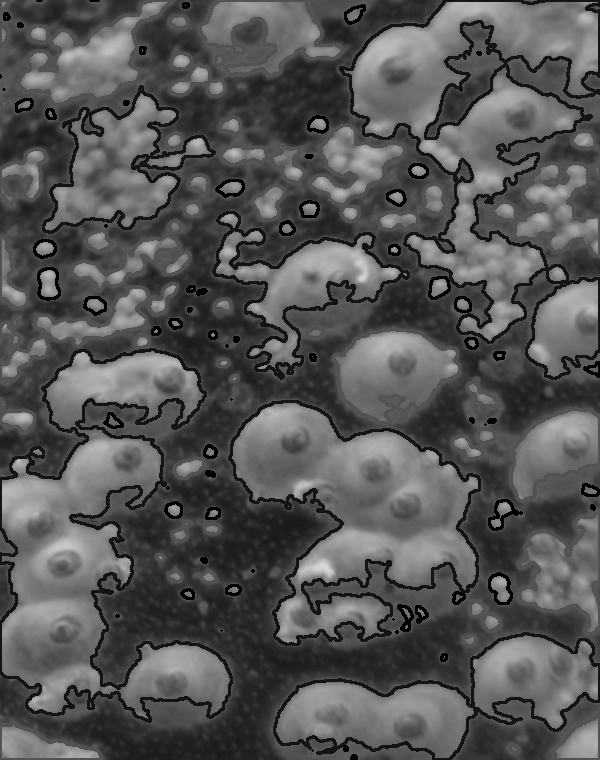

In [106]:
conts = [[],[],[],[]] #contour list

for cont, cnt in enumerate(contours):
    class_ = kmeans.predict([df.iloc[cont]])[0]
    conts[class_].append(cnt)
    
if n_clusters == 3:
    im = cv.drawContours(corte, conts[0], -1, (0, 0, 0), thickness=2)
    im = cv.drawContours(im, conts[1], -1, (20, 150, 232), thickness=2)
    im = cv.drawContours(im, conts[2], -1, (82, 184, 10), thickness=2)
elif n_clusters == 2:
    im = cv.drawContours(im, conts[0], -1, (0, 0, 0), thickness=2)
    im = cv.drawContours(im, conts[1], -1, (20, 150, 232), thickness=2)
            
print('class 0: ' + str(len(conts[0])) + ' individuals')
print('class 1: ' + str(len(conts[1])) + ' individuals')
print('class 2: ' + str(len(conts[2])) + ' individuals')
print('class 3: ' + str(len(conts[3])) + ' individuals')

cv2_imshow(im)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/pytho

class 0: 70 individuals
class 1: 6 individuals
class 2: 66 individuals
class 3: 0 individuals


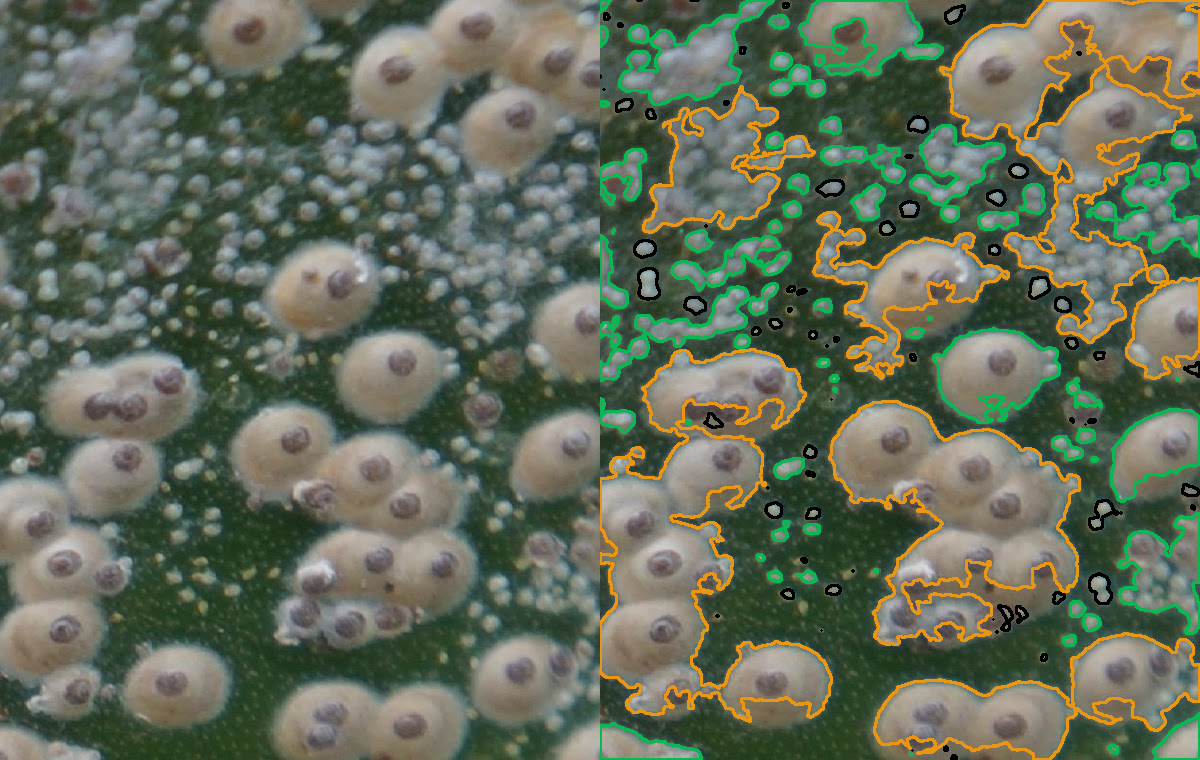

In [107]:
conts = [[],[],[],[]] #contour list

for cont, cnt in enumerate(contours):
    class_ = kmeans.predict([df.iloc[cont]])[0]
    conts[class_].append(cnt)
    
if n_clusters == 3:
    im = cv.drawContours(corteIm, conts[0], -1, (0, 0, 0), thickness=2)
    im = cv.drawContours(im, conts[1], -1, (20, 150, 232), thickness=2)
    im = cv.drawContours(im, conts[2], -1, (82, 184, 10), thickness=2)
elif n_clusters == 2:
    im = cv.drawContours(im, conts[0], -1, (0, 0, 0), thickness=2)
    im = cv.drawContours(im, conts[1], -1, (20, 150, 232), thickness=2)
            
print('class 0: ' + str(len(conts[0])) + ' individuals')
print('class 1: ' + str(len(conts[1])) + ' individuals')
print('class 2: ' + str(len(conts[2])) + ' individuals')
print('class 3: ' + str(len(conts[3])) + ' individuals')

#cv2_imshow(corteIm)
cv2_imshow(cv.hconcat([compara, corteIm]))